In [2]:
import pandas as pd
import numpy as np
import decoupler as dc
import seaborn as sns
import gseapy as gp
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors
import json
import scipy as sp
from plot_lib import plot_bubbles, plot_enrich
from plotnine import ggsave

In [3]:
#Okabe- Ito palette
pal = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F5C710", "#0072B2", "#D55E00", "#CC79A7", "#999999"]

# define top and bottom colormaps 
top = plt.get_cmap('Oranges_r', 128) # r means reversed version
bottom = plt.get_cmap('Blues', 128)# combine it all
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))# create a new colormaps with a name of OrangeBlue
orange_blue = colors.ListedColormap(newcolors, name='OrangeBlue')

In [4]:
color_pal = {}
for x in zip(["CollecTri", "M2Kb_K-562", "M2Kb_MCF-7", "M2Kb_HepG2", "M2Kb_GM-12878", "CA_K-562", "CA_MCF-7", "CA_HepG2", "CA_GM-12878"], 
             [pal[7], pal[2], pal[3], pal[4], pal[8], pal[1], pal[0], pal[5], pal[6]]):
    color_pal[x[0]] = colors.to_rgba(x[1])
    
cmap = matplotlib.colors.ListedColormap([pal[7], pal[2], pal[3], pal[4], pal[8], pal[1], pal[0], pal[5], pal[6]])
net_dict = {"CollecTri": 7, 
            "M2Kb_K-562": 2, 
            "M2Kb_MCF-7": 3, 
            "M2Kb_HepG2": 4, 
            "M2Kb_GM-12878": 8,
            "CA_K-562": 1,
            "CA_MCF-7": 0,
            "CA_HepG2": 5,
            "CA_GM-12878": 6}

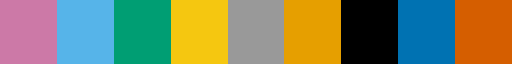

In [5]:
cmap

Network data loading

In [6]:
collectri = dc.get_collectri(organism='human', split_complexes=False)

In [7]:
chip_atlas_k562 = pd.read_table("../data/regulons/ChIP-Atlas_target_genes_K562.tsv", sep="\t")

In [8]:
chip_atlas_k562.head()

,tf,Target_genes
0,ADNP,TRMT2A
1,ADNP,RANBP1
2,ADNP,OSCAR
3,ADNP,NDUFA3
4,ADNP,PSMD9


In [9]:
k562 = pd.read_table("../data/regulons/K562_all_regulons.tsv", sep="\t")

k562 = k562.loc[k562.is_method_2 & k562.is_atac, ["tf", "gene_symbol"]].drop_duplicates(["tf", "gene_symbol"])
k562 = k562.loc[k562.tf.isin(collectri.source) & k562.tf.isin(chip_atlas_k562.tf)]
k562.shape

(1429281, 2)

In [10]:
chip_atlas_k562 = chip_atlas_k562.loc[chip_atlas_k562.tf.isin(k562.tf)]
chip_atlas_k562.shape

(1086521, 2)

In [11]:
chip_atlas_gm12878 = pd.read_table("../data/regulons/ChIP-Atlas_target_genes_GM12878.tsv", sep="\t")

In [12]:
gm12878 = pd.read_table("../data/regulons/GM12878_all_regulons.tsv", sep="\t")

gm12878 = gm12878.loc[gm12878.is_method_2 & gm12878.is_atac, ["tf", "gene_symbol"]].drop_duplicates(["tf", "gene_symbol"])
gm12878 = gm12878.loc[gm12878.tf.isin(collectri.source) & gm12878.tf.isin(chip_atlas_gm12878.tf)]
gm12878.shape

(550280, 2)

In [13]:
chip_atlas_gm12878 = chip_atlas_gm12878.loc[chip_atlas_gm12878.tf.isin(gm12878.tf)]
chip_atlas_gm12878.shape

(1576755, 2)

In [14]:
collectri = collectri[collectri.source.isin(k562.tf) | collectri.source.isin(gm12878.tf)]

### Prepare cosmic

In [15]:
COSMIC = dc.get_resource('CancerGeneCensus')

COSMIC.tumour_types_somatic = COSMIC.tumour_types_somatic.str.split(";")

COSMIC = COSMIC.explode("tumour_types_somatic")
cosmic_dict = {}
for typ in COSMIC.tumour_types_somatic.drop_duplicates():
    if COSMIC.loc[COSMIC.tumour_types_somatic == typ].genesymbol.shape[0] > 1:
        cosmic_dict[typ] = COSMIC.loc[COSMIC.tumour_types_somatic == typ].genesymbol.to_list()

### C6 cells leukemic vs healthy

In [16]:
data = pd.read_csv("../data/case_study/c6_leukemic_vs_healthy_aml_dataset.csv", sep=";", index_col=0)
#data = pd.read_csv("data/aml_case_study/c6_vs_other_cells_aml_dataset.csv", sep=";", index_col=0)
#data = pd.read_csv("data/aml_case_study/c6_vs_other_leukemic_cells_aml_dataset.csv", sep=";", index_col=0)
data

,n patients up,n patients down,Mean log2 Fold Change,SD log2 FC,Sum of log p values,n patients significant (consistent sign),Metadata: Rodriguez-Fraticelli,Metadata: Zhang
Gene,,,,,,,,
BST2,5,0,"1,7700744366",1,25,5,Other,dHSC
CFD,0,5,"-1,5632001468",1,17,5,Other,Other
IFITM3,5,0,"1,3214619090",1,22,5,dHSC,Other
ALDH1A1,4,0,"1,1047309844",1,20,4,dHSC,Other
AVP,4,0,"2,8423696458",1,29,4,Other,dHSC
...,...,...,...,...,...,...,...,...
VSIR,1,1,"0,0047056800",0,5,0,Other,Other
YWHAE,1,1,"0,0690342600",0,6,0,Other,Other
ZFAND1,1,1,"-0,1537241000",1,7,0,Other,Other


In [17]:
#data = data[data["Metadata: Velten"] == "Erythromyeloid priming"]
de_genes = data.loc[data["n patients significant (consistent sign)"] > 0]["Mean log2 Fold Change"].str.replace(",",'.').astype("float").to_frame()
de_genes.head()
de_genes["leukemic"] = - de_genes["Mean log2 Fold Change"]
de_genes

,Mean log2 Fold Change,leukemic
Gene,,
BST2,1.770074,-1.770074
CFD,-1.563200,1.563200
IFITM3,1.321462,-1.321462
ALDH1A1,1.104731,-1.104731
AVP,2.842370,-2.842370
...,...,...
ZNF700,-0.293188,0.293188
ZNF71,-0.539847,0.539847
ZNF711,0.432657,-0.432657


In [18]:
de_genes.loc[de_genes.leukemic.abs() > 1]

,Mean log2 Fold Change,leukemic
Gene,,
BST2,1.770074,-1.770074
CFD,-1.563200,1.563200
IFITM3,1.321462,-1.321462
ALDH1A1,1.104731,-1.104731
AVP,2.842370,-2.842370
...,...,...
TPSAB1,-1.774639,1.774639
TRIM28,-1.120366,1.120366
TUBA1C,-1.011307,1.011307


In [19]:
enr = gp.enrich(de_genes.loc[de_genes["leukemic"].abs() > 1, :].index.to_list(), "DisGeNET")

enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,DisGeNET,leukemia,64/1941,9.533245e-19,3.989663e-15,0,0,4.561105,189.260002,KDM5B;CXCL8;CSF1;PLEK;HPGDS;LGALS1;MYC;CASP3;S...
1,DisGeNET,"Leukemia, Myelocytic, Acute",55/1703,1.426761e-15,2.720491e-12,0,0,4.236837,144.829371,CXCL8;CSF1;MSLN;HPGDS;MYC;CASP3;STMN1;PIM1;CD3...
2,DisGeNET,Rheumatoid Arthritis,57/1833,1.950173e-15,2.720491e-12,0,0,4.103100,138.975534,BTG2;CD84;CXCL8;CSF1;NCF4;PLEK;BHLHE41;ICAM3;C...
3,DisGeNET,Acute lymphocytic leukemia,39/907,6.091788e-15,6.373533e-12,0,0,5.350448,175.129973,CXCL8;CSF1;GSTP1;MLLT3;MSLN;GATA1;P2RY8;SOCS3;...
4,DisGeNET,"Lupus Erythematosus, Systemic",43/1113,8.424787e-15,7.051547e-12,0,0,4.856654,157.392478,FOXC1;CD84;CXCL8;CSF1;GSTP1;ICAM3;CLU;SOCS2;SO...
...,...,...,...,...,...,...,...,...,...,...
4180,DisGeNET,Mitochondrial Diseases,2/384,8.962123e-01,8.970697e-01,0,0,0.518752,0.056844,CASP3;SOD2
4181,DisGeNET,Visual Impairment,1/251,9.189818e-01,9.196411e-01,0,0,0.396995,0.033542,ARID1B
4182,DisGeNET,Cerebellar Ataxia,3/565,9.212140e-01,9.216545e-01,0,0,0.526690,0.043222,TUBB;CASP3;NBN
4183,DisGeNET,Low Vision,1/261,9.267492e-01,9.269707e-01,0,0,0.381531,0.029024,ARID1B


In [20]:
de_genes.drop("Mean log2 Fold Change", axis=1, inplace=True)

In [21]:
de_genes = de_genes.T

In [22]:
dc.check_corr(k562, mat=de_genes, source="tf", target="gene_symbol", weight=None).sort_values("corr")

,source1,source2,corr
10264,GTF2B,RBFOX2,-0.1837
19695,CEBPD,RBFOX2,-0.0851
19696,E2F1,GATAD2B,-0.0851
20217,BRCA1,MYC,-0.0809
20331,RBFOX2,SIRT6,-0.0800
...,...,...,...
4,HDAC1,MYC,0.6507
3,MNT,SIN3A,0.6528
2,SMAD5,TAF1,0.6600
1,CREM,JUND,0.6691


In [23]:
dc.check_corr(collectri, mat=de_genes, weight=None).sort_values("corr")

,source1,source2,corr
3601,E2F4,SP1,-0.0742
3840,SREBF1,TP53,-0.0676
4083,KLF1,SP1,-0.0598
4184,MYC,SREBF2,-0.0566
4213,E2F6,SP1,-0.0554
...,...,...,...
4,SMAD1,SMAD5,0.5298
3,FOS,JUN,0.5309
2,USF1,USF2,0.5554
1,CTNNB1,TCF7L2,0.5926


In [24]:
aml_disreg_enrich = pd.DataFrame()
aml_omim_enrich = pd.DataFrame()
aml_cosmic_enrich = pd.DataFrame()
megaheat = pd.DataFrame()

K562

In [25]:
tf_acts_k562, tf_pvals_k562= dc.run_ulm(de_genes, k562, source='tf', target='gene_symbol', weight=None)

#tf_pvals.loc["leukemic"] = fdrcorrection(tf_pvals.T["leukemic"])[1]

In [26]:
mask = tf_pvals_k562< 0.01

active_tfs_k562 = tf_acts_k562.loc["leukemic", pd.DataFrame(tf_acts_k562 * mask).sum(axis=0) != 0].index.to_list()

In [27]:
tf_acts_k562.index = ["score"]
tf_pvals_k562.index = ["p_value"]
out_k562 = pd.merge(left=tf_acts_k562.T, right=tf_pvals_k562.T, left_index=True, right_index=True)
out_k562.to_csv("../data/3-tf_activity/aml_dhsc_ahsc_activity_m2kb_k562.tsv", sep="\t", index=False)

In [28]:
enr = gp.enrich(active_tfs_k562, "OMIM_Expanded")
enr.results["Network"] = "M2Kb_K-562"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_omim_enrich_m2kb_k562_dhsc_ahsc.tsv", sep="\t", index=False)
aml_omim_enrich = pd.concat([aml_omim_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [29]:
enr = gp.enrich(active_tfs_k562, "DisGeNET")
enr.results["Network"] = "M2Kb_K-562"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_disgenet_enrich_m2kb_k562_dhsc_ahsc.tsv", sep="\t", index=False)
aml_disreg_enrich = pd.concat([aml_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [30]:
try:
    enr = gp.enrich(gene_list=active_tfs_k562, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "M2Kb_K-562"
    enr.results.to_csv("../data/3-tf_disease_enrichment/aml_cosmic_enrich_m2kb_k562_dhsc_ahsc.tsv", sep="\t", index=False)
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "M2Kb_K-562"
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, pd.DataFrame()], axis=0)

In [31]:
heat = pd.concat([tf_acts_k562.rename({"leukemic": "score"}), tf_pvals_k562.rename({"leukemic": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=False).index).head(5)
heat["Network"] = "M2Kb_K-562"
#heat["TFs"] = heat.index
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat

,score,p_value,Network
ADNP,0.846599,0.397313,M2Kb_K-562
ARHGAP35,0.830466,0.406367,M2Kb_K-562
ARID1B,-0.798591,0.424616,M2Kb_K-562
ARID3A,0.997109,0.318823,M2Kb_K-562
ARID3B,0.419137,0.675158,M2Kb_K-562
...,...,...,...
ZNF436,0.719621,0.471837,M2Kb_K-562
ZNF444,0.917586,0.358938,M2Kb_K-562
ZNF76,2.253708,0.024315,M2Kb_K-562
ZNF77,1.509189,0.131397,M2Kb_K-562


CollecTri

In [32]:
tf_acts_ctri, tf_pvals_ctri = dc.run_ulm(de_genes, collectri)
#tf_pvals_ctri.loc["leukemic"] = fdrcorrection(tf_pvals_ctri.T["leukemic"])[1]

In [33]:
mask_ctri = tf_pvals_ctri < 0.01
active_tfs_ctri = tf_acts_ctri.loc["leukemic", pd.DataFrame(tf_acts_ctri * mask_ctri).sum(axis=0) != 0].index.to_list()
tf_acts_ctri.loc["leukemic", pd.DataFrame(tf_acts_ctri * mask_ctri).sum(axis=0) != 0]

ATF3    -2.941248
CREB1   -3.624266
IRF1    -4.248643
KLF1     2.616677
MEF2A   -2.943967
MITF     4.227231
NFE2     4.751493
NR2C2   -2.769127
RELA    -2.857900
RFX1    -5.004245
RFX5    -8.666896
THRA    -3.440546
YBX1    -2.735002
YY1     -3.571998
Name: leukemic, dtype: float32

In [34]:
tf_acts_ctri.index = ["score"]
tf_pvals_ctri.index = ["p_value"]
out_ctri = pd.merge(left=tf_acts_ctri.T, right=tf_pvals_ctri.T, left_index=True, right_index=True)
out_ctri.to_csv("../data/3-tf_activity/aml_dhsc_ahsc_activity_collectri.tsv", sep="\t", index=False)

In [35]:
enr = gp.enrich(active_tfs_ctri, "OMIM_Expanded")
enr.results["Network"] = "CollecTri"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_omim_enrich_collectri_dhsc_ahsc.tsv", sep="\t", index=False)
aml_omim_enrich = pd.concat([aml_omim_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [36]:
enr = gp.enrich(active_tfs_ctri, "DisGeNET")
enr.results["Network"] = "CollecTri"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_disgenet_enrich_collectri_dhsc_ahsc.tsv", sep="\t", index=False)
aml_disreg_enrich = pd.concat([aml_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [37]:
try:
    enr = gp.enrich(gene_list=active_tfs_ctri, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "CollecTri"
    enr.results.to_csv("../data/3-tf_disease_enrichment/aml_cosmic_enrich_collectri_dhsc_ahsc.tsv", sep="\t", index=False)
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "CollecTri"
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, pd.DataFrame()], axis=0)

In [38]:
heat = pd.concat([tf_acts_ctri.rename({"leukemic": "score"}), tf_pvals_ctri.rename({"leukemic": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=False).index).head(5)
heat["Network"] = "CollecTri"
#heat["TFs"] = heat.index
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat

,score,p_value,Network
ADNP,0.846599,0.397313,M2Kb_K-562
ARHGAP35,0.830466,0.406367,M2Kb_K-562
ARID1B,-0.798591,0.424616,M2Kb_K-562
ARID3A,0.997109,0.318823,M2Kb_K-562
ARID3B,0.419137,0.675158,M2Kb_K-562
...,...,...,...
YY1,-3.571998,0.000362,CollecTri
ZBED1,0.267935,0.788775,CollecTri
ZBTB7A,-0.141364,0.887595,CollecTri
ZEB1,1.985951,0.047165,CollecTri


GM12878

In [39]:
tf_acts_gm12878, tf_pvals_gm12878 = dc.run_ulm(de_genes, gm12878, source='tf', target='gene_symbol', weight=None)

#tf_pvals_gm12878.loc["leukemic"] = fdrcorrection(tf_pvals_gm12878.T["leukemic"])[1]

In [40]:
mask_gm12878 = tf_pvals_gm12878 < 0.01

active_tfs_gm12878 = tf_acts_gm12878.loc["leukemic", pd.DataFrame(tf_acts_gm12878 * mask_gm12878).sum(axis=0) != 0].index.to_list()

In [41]:
tf_acts_gm12878.index = ["score"]
tf_pvals_gm12878.index = ["p_value"]
out_gm12878 = pd.merge(left=tf_acts_gm12878.T, right=tf_pvals_gm12878.T, left_index=True, right_index=True)
out_gm12878.to_csv("../data/3-tf_activity/aml_dhsc_ahsc_activity_m2kb_gm12878.tsv", sep="\t", index=False)

In [42]:
try:
    enr = gp.enrich(gene_list=active_tfs_gm12878, gene_sets="OMIM_Expanded")
    enr.results["Network"] = "M2Kb_GM-12878"
    enr.results.to_csv("../data/3-tf_disease_enrichment/aml_omim_enrich_m2kb_gm12878_dhsc_ahsc.tsv", sep="\t", index=False)
    aml_omim_enrich = pd.concat([aml_omim_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except:
    enr.results["Network"] = "M2Kb_GM-12878"
    aml_omim_enrich = pd.concat([aml_omim_enrich, pd.DataFrame()], axis=0)

In [43]:
try:
    enr = gp.enrich(gene_list=active_tfs_gm12878, gene_sets="DisGeNET")
    enr.results["Network"] = "M2Kb_GM-12878"
    enr.results.to_csv("../data/3-tf_disease_enrichment/aml_disgenet_enrich_m2kb_gm12878_dhsc_ahsc.tsv", sep="\t", index=False)
    aml_disreg_enrich = pd.concat([aml_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except:
    enr.results["Network"] = "M2Kb_GM-12878"
    aml_disreg_enrich = pd.concat([aml_disreg_enrich, pd.DataFrame()], axis=0)

In [44]:
try:
    enr = gp.enrich(gene_list=active_tfs_gm12878, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "M2Kb_GM-12878"
    enr.results.to_csv("../data/3-tf_disease_enrichment/aml_cosmic_enrich_m2kb_gm12878_dhsc_ahsc.tsv", sep="\t", index=False)
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "M2Kb_GM-12878"
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, pd.DataFrame()], axis=0)

In [45]:
heat = pd.concat([tf_acts_gm12878.rename({"leukemic": "score"}), tf_pvals_gm12878.rename({"leukemic": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=False).index).head(5)
heat["Network"] = "M2Kb_GM-12878"
#heat["TFs"] = heat.index
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat

,score,p_value,Network
ADNP,0.846599,0.397313,M2Kb_K-562
ARHGAP35,0.830466,0.406367,M2Kb_K-562
ARID1B,-0.798591,0.424616,M2Kb_K-562
ARID3A,0.997109,0.318823,M2Kb_K-562
ARID3B,0.419137,0.675158,M2Kb_K-562
...,...,...,...
ZEB1,3.590709,0.000337,M2Kb_GM-12878
ZNF143,3.535664,0.000415,M2Kb_GM-12878
ZNF217,3.020763,0.002551,M2Kb_GM-12878
ZNF24,1.362036,0.173329,M2Kb_GM-12878


chip_atlas_k562

In [46]:
tf_acts_chip_atlas_k562, tf_pvals_chip_atlas_k562= dc.run_ulm(de_genes, chip_atlas_k562.drop_duplicates(), source='tf', target='Target_genes', weight=None)

#tf_pvals.loc["leukemic"] = fdrcorrection(tf_pvals.T["leukemic"])[1]

In [47]:
mask = tf_pvals_chip_atlas_k562 < 0.01

active_tfs_chip_atlas_k562 = tf_acts_chip_atlas_k562.loc["leukemic", pd.DataFrame(tf_acts_chip_atlas_k562 * mask).sum(axis=0) != 0].index.to_list()

In [48]:
active_tfs_chip_atlas_k562

['ATF1',
 'ATF7',
 'BCOR',
 'BHLHE40',
 'BRD4',
 'CEBPD',
 'CREB1',
 'CREB3L1',
 'CREM',
 'CTBP1',
 'CTCF',
 'CTCFL',
 'E2F4',
 'E2F5',
 'E2F6',
 'E4F1',
 'EGR1',
 'ELF1',
 'ELF4',
 'ELK1',
 'ERG',
 'ESRRA',
 'ETS1',
 'FOSL1',
 'GABPA',
 'GATA1',
 'GATAD2B',
 'GFI1B',
 'GMEB1',
 'GTF2B',
 'GTF2F1',
 'HCFC1',
 'HDAC1',
 'HEY1',
 'IRF1',
 'JUN',
 'JUND',
 'KDM5B',
 'MAX',
 'MAZ',
 'MBD2',
 'MGA',
 'MNT',
 'MTA3',
 'MXI1',
 'MYC',
 'NCOR1',
 'NFIC',
 'NFYA',
 'NFYB',
 'NONO',
 'NR2C2',
 'NRF1',
 'PHF8',
 'PLAG1',
 'PML',
 'RB1',
 'RBFOX2',
 'RCOR1',
 'REST',
 'RFX5',
 'SAP30',
 'SIN3A',
 'SIN3B',
 'SKIL',
 'SMAD5',
 'SMARCA4',
 'SP1',
 'SPI1',
 'SRF',
 'TAF1',
 'TBP',
 'TEAD1',
 'TFDP1',
 'THAP1',
 'UBTF',
 'USF1',
 'USF2',
 'VEZF1',
 'YY1',
 'ZBTB7A',
 'ZFX',
 'ZNF148',
 'ZNF281',
 'ZNF395']

In [49]:
tf_acts_chip_atlas_k562.index = ["score"]
tf_pvals_chip_atlas_k562.index = ["p_value"]
out_chip_atlas_k562 = pd.merge(left=tf_acts_chip_atlas_k562.T, right=tf_pvals_chip_atlas_k562.T, left_index=True, right_index=True)
out_chip_atlas_k562.to_csv("../data/3-tf_activity/aml_dhsc_ahsc_activity_ca_k562.tsv", sep="\t", index=False)

In [50]:
enr = gp.enrich(active_tfs_chip_atlas_k562, "OMIM_Expanded")
enr.results["Network"] = "CA_K-562"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_omim_enrich_ca_k562_dhsc_ahsc.tsv", sep="\t", index=False)
aml_omim_enrich = pd.concat([aml_omim_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [51]:
enr = gp.enrich(active_tfs_chip_atlas_k562, "DisGeNET")
enr.results["Network"] = "CA_K-562"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_disgenet_enrich_ca_k562_dhsc_ahsc.tsv", sep="\t", index=False)
aml_disreg_enrich = pd.concat([aml_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [52]:
try:
    enr = gp.enrich(gene_list=active_tfs_chip_atlas_k562, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "CA_K-562"
    enr.results.to_csv("../data/3-tf_disease_enrichment/aml_cosmic_enrich_ca_k562_dhsc_ahsc.tsv", sep="\t", index=False)
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "CA_K-562"
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, pd.DataFrame()], axis=0)

In [53]:
heat = pd.concat([tf_acts_chip_atlas_k562.rename({"leukemic": "score"}), tf_pvals_chip_atlas_k562.rename({"leukemic": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=False).index).head(5)
heat["Network"] = "CA_K-562"
#heat["TFs"] = heat.index
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat

,score,p_value,Network
ADNP,0.846599,0.397313,M2Kb_K-562
ARHGAP35,0.830466,0.406367,M2Kb_K-562
ARID1B,-0.798591,0.424616,M2Kb_K-562
ARID3A,0.997109,0.318823,M2Kb_K-562
ARID3B,0.419137,0.675158,M2Kb_K-562
...,...,...,...
ZNF436,0.343921,0.730939,CA_K-562
ZNF444,0.488123,0.625513,CA_K-562
ZNF76,0.664738,0.506289,CA_K-562
ZNF77,-0.207646,0.835525,CA_K-562


chip_atlas_12878

In [54]:
tf_acts_chip_atlas_gm12878, tf_pvals_chip_atlas_gm12878 = dc.run_ulm(de_genes, chip_atlas_gm12878.drop_duplicates(), 
                                                                     source='tf', target='Target_genes', weight=None)

#tf_pvals_chip_atlas_gm12878.loc["leukemic"] = fdrcorrection(tf_pvals_chip_atlas_gm12878.T["leukemic"])[1]

In [55]:
mask_chip_atlas_gm12878 = tf_pvals_chip_atlas_gm12878 < 0.01

active_tfs_chip_atlas_gm12878 = tf_acts_chip_atlas_gm12878.loc["leukemic", pd.DataFrame(tf_acts_chip_atlas_gm12878 * mask_chip_atlas_gm12878).sum(axis=0) != 0].index.to_list()
tf_acts_chip_atlas_gm12878.loc["leukemic", pd.DataFrame(tf_acts_chip_atlas_gm12878 * mask_chip_atlas_gm12878).sum(axis=0) != 0]

BACH1      2.702389
CEBPB     -2.807492
CREB1      3.177533
CREM       3.346181
EGR1       3.609958
ELF1       3.485574
ELK1       2.805024
ETS1       2.662564
GABPA      4.147079
GATAD2B    4.509802
HCFC1      4.259727
IKZF1      2.699850
MAX        3.035635
MAZ        3.892797
MED1       4.656500
MEF2B      3.319759
MXI1       3.796656
NR2C1      3.142843
NR2F1      3.693578
NRF1       2.732646
PML        4.047319
RB1        3.204776
SIN3A      3.392981
SMAD1     -4.978426
SP1        2.824545
SRF        3.198567
TAF1       4.278240
USF1       4.483429
USF2       2.977548
YY1        4.213799
ZNF143     3.538239
Name: leukemic, dtype: float32

In [56]:
tf_acts_chip_atlas_gm12878.index = ["score"]
tf_pvals_chip_atlas_gm12878.index = ["p_value"]
out_chip_atlas_gm12878 = pd.merge(left=tf_acts_chip_atlas_gm12878.T, right=tf_pvals_chip_atlas_gm12878.T, left_index=True, right_index=True)
out_chip_atlas_gm12878.to_csv("../data/3-tf_activity/aml_dhsc_ahsc_activity_ca_gm12878.tsv", sep="\t", index=False)

In [57]:
try:
    enr = gp.enrich(gene_list=active_tfs_chip_atlas_gm12878, gene_sets="OMIM_Expanded")
    enr.results["Network"] = "CA_GM-12878"
    enr.results.to_csv("../data/3-tf_disease_enrichment/aml_omim_enrich_ca_gm12878_dhsc_ahsc.tsv", sep="\t", index=False)
    aml_omim_enrich = pd.concat([aml_omim_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except:
    enr.results["Network"] = "CA_GM-12878"
    aml_omim_enrich = pd.concat([aml_omim_enrich, pd.DataFrame()], axis=0)

In [58]:
try:
    enr = gp.enrich(gene_list=active_tfs_chip_atlas_gm12878, gene_sets="DisGeNET")
    enr.results["Network"] = "CA_GM-12878"
    enr.results.to_csv("../data/3-tf_disease_enrichment/aml_disgenet_enrich_ca_gm12878_dhsc_ahsc.tsv", sep="\t", index=False)
    aml_disreg_enrich = pd.concat([aml_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except:
    enr.results["Network"] = "CA_GM-12878"
    aml_disreg_enrich = pd.concat([aml_disreg_enrich, pd.DataFrame()], axis=0)

In [59]:
try:
    enr = gp.enrich(gene_list=active_tfs_chip_atlas_gm12878, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "CA_GM-12878"
    enr.results.to_csv("../data/3-tf_disease_enrichment/aml_cosmic_enrich_ca_gm12878_dhsc_ahsc.tsv", sep="\t", index=False)
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "CA_GM-12878"
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, pd.DataFrame()], axis=0)

In [60]:
heat = pd.concat([tf_acts_chip_atlas_gm12878.rename({"leukemic": "score"}), tf_pvals_chip_atlas_gm12878.rename({"leukemic": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=False).index).head(5)
heat["Network"] = "CA_GM-12878"
#heat["TFs"] = heat.index
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat

,score,p_value,Network
ADNP,0.846599,0.397313,M2Kb_K-562
ARHGAP35,0.830466,0.406367,M2Kb_K-562
ARID1B,-0.798591,0.424616,M2Kb_K-562
ARID3A,0.997109,0.318823,M2Kb_K-562
ARID3B,0.419137,0.675158,M2Kb_K-562
...,...,...,...
ZEB1,1.580310,0.114183,CA_GM-12878
ZNF143,3.538239,0.000411,CA_GM-12878
ZNF217,0.814463,0.415470,CA_GM-12878
ZNF24,0.266810,0.789641,CA_GM-12878


In [61]:
aml_disreg_enrich

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Network
0,DisGeNET,Carcinogenesis,66/4065,9.115051e-27,2.255063e-23,0,0,10.503226,629.772060,RB1;KDM5B;CTCF;ETS1;PHF8;YY1;SIN3B;ZMIZ1;SIN3A...,M2Kb_K-562
1,DisGeNET,Tumor Progression,49/2090,9.715883e-25,1.201855e-21,0,0,10.213621,564.719931,RB1;KDM5B;CTCF;ETS1;YY1;SIN3B;CREB3L1;MYC;GABP...,M2Kb_K-562
2,DisGeNET,Malignant neoplasm of prostate,55/3239,1.376395e-21,1.135067e-18,0,0,8.025152,385.486713,RB1;KDM5B;CTCF;ETS1;PHF8;YY1;SIN3B;ZMIZ1;MYC;E...,M2Kb_K-562
3,DisGeNET,Prostate carcinoma,54/3145,2.662436e-21,1.646717e-18,0,0,7.940857,376.198465,RB1;KDM5B;CTCF;ETS1;PHF8;YY1;SIN3B;ZMIZ1;MYC;E...,M2Kb_K-562
4,DisGeNET,Breast Carcinoma,65/4963,1.001233e-20,4.954099e-18,0,0,7.661801,352.829526,RB1;KDM5B;CTCF;ETS1;YY1;SIN3B;ZMIZ1;SIN3A;CREB...,M2Kb_K-562
0,DisGeNET,Liver neoplasms,8/1321,7.437670e-07,5.146268e-04,0,0,18.962173,267.585426,YY1;CREB1;THRA;IRF1;YBX1;NR2C2;RELA;ATF3,CollecTri
1,DisGeNET,Liver carcinoma,11/3593,1.320840e-06,5.146268e-04,0,0,16.791736,227.313816,MEF2A;YY1;CREB1;THRA;IRF1;MITF;YBX1;RFX1;NR2C2...,CollecTri
2,DisGeNET,Tumor Progression,9/2090,1.793125e-06,5.146268e-04,0,0,15.487266,204.920543,YY1;CREB1;IRF1;MITF;YBX1;RFX1;NR2C2;RELA;ATF3,CollecTri
3,DisGeNET,Carcinogenesis,11/4065,4.755552e-06,9.502232e-04,0,0,14.409801,176.609372,MEF2A;YY1;CREB1;THRA;IRF1;MITF;YBX1;RFX1;NR2C2...,CollecTri
4,DisGeNET,Mammary Neoplasms,9/2387,5.518137e-06,9.502232e-04,0,0,13.328175,161.370482,MEF2A;YY1;CREB1;THRA;IRF1;YBX1;NR2C2;RELA;ATF3,CollecTri


Plotting results

In [62]:
okabe = [pal[6], pal[1], pal[7], pal[8], pal[2]]

In [63]:
aml_omim_enrich["-log10(Adj. P-value)"] = - np.log10(aml_omim_enrich["Adjusted P-value"])
aml_omim_enrich = aml_omim_enrich.loc[aml_omim_enrich["Adjusted P-value"] < 0.05]
aml_omim_enrich.describe()

,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,2.500000e+01,2.500000e+01,25.0,25.0,25.000000,25.000000,25.000000
mean,3.139615e-04,5.192013e-04,0.0,0.0,35.712323,477.054263,4.250053
std,4.079176e-04,5.948496e-04,0.0,0.0,32.102006,520.039334,1.481558
min,4.321183e-10,7.994189e-08,0.0,0.0,11.799494,89.290530,2.777654
25%,2.673751e-07,1.164065e-05,0.0,0.0,16.127435,109.538487,3.095538
50%,1.306213e-05,4.948599e-04,0.0,0.0,21.186966,217.752116,3.305518
75%,5.170772e-04,8.025306e-04,0.0,0.0,31.250983,499.340022,4.934023
max,1.122655e-03,1.668576e-03,0.0,0.0,100.794937,1525.492377,7.097226


/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/aml_go_enrich_omim_dhsc_ahsc_new.svg


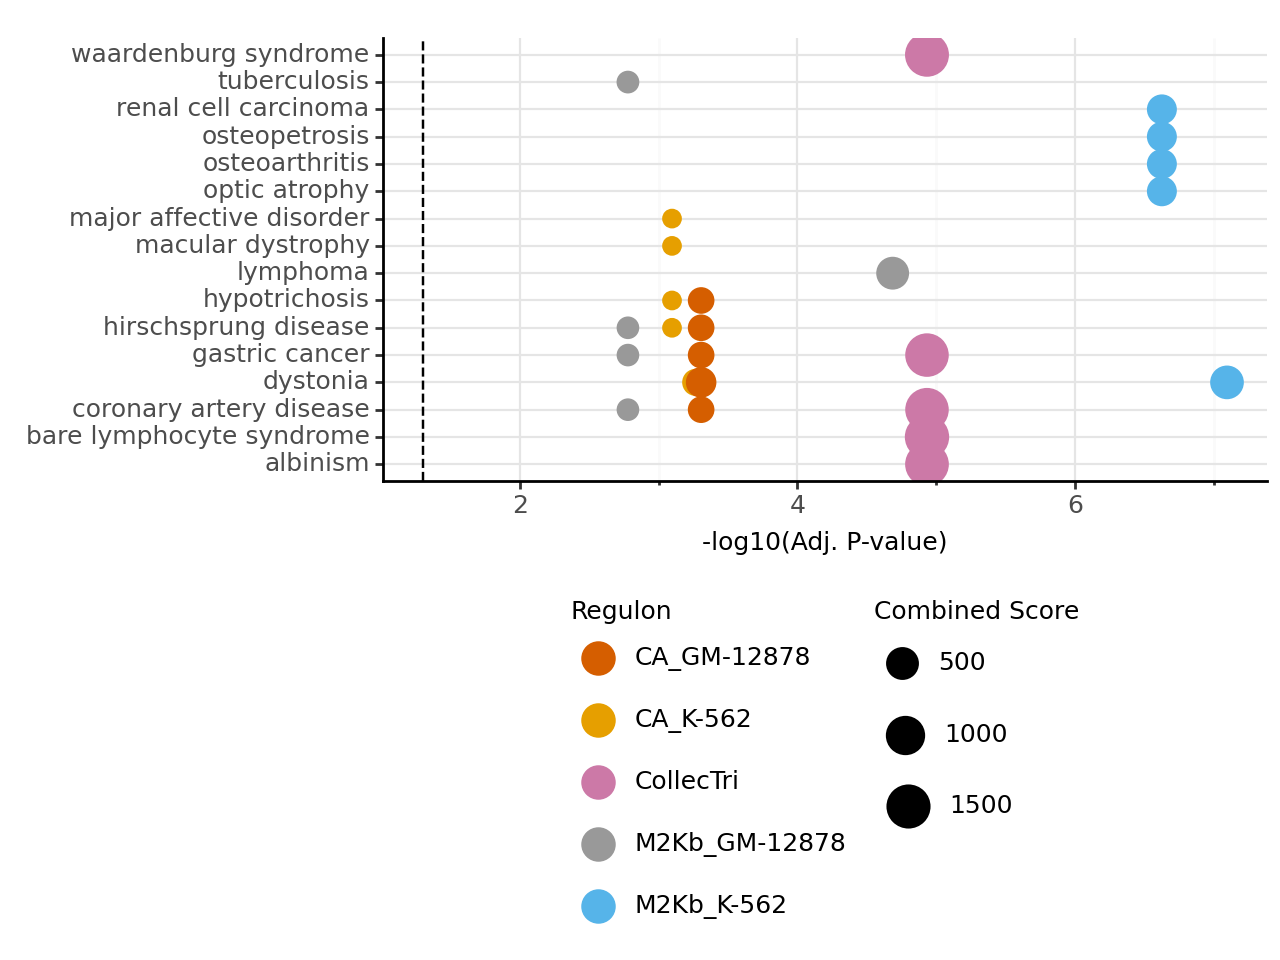

<Figure Size: (640 x 480)>

In [64]:
p = plot_enrich(aml_omim_enrich, okabe)
ggsave(p, "../plots/3-tf_disease_enrichment/aml_go_enrich_omim_dhsc_ahsc_new.svg",  width = 30, height = 150, units = "mm", dpi=720)
p

In [65]:
aml_disreg_enrich["-log10(Adj. P-value)"] = - np.log10(aml_disreg_enrich["Adjusted P-value"])
aml_disreg_enrich = aml_disreg_enrich.loc[aml_disreg_enrich["Adjusted P-value"] < 0.05]
aml_disreg_enrich.describe()

,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,2.500000e+01,2.500000e+01,25.0,25.0,25.000000,25.000000,25.000000
mean,5.653863e-07,1.378152e-04,0.0,0.0,10.482357,290.164554,10.361876
std,1.451819e-06,2.975977e-04,0.0,0.0,3.563998,125.282492,6.075519
min,9.115051e-27,2.255063e-23,0.0,0.0,6.077404,159.704028,3.022174
25%,1.550373e-19,1.749596e-16,0.0,0.0,7.661801,204.920543,6.486944
50%,6.220537e-11,3.872783e-08,0.0,0.0,10.213621,244.243963,7.411977
75%,1.128046e-09,3.258787e-07,0.0,0.0,13.328175,369.059962,15.757062
max,5.518137e-06,9.502232e-04,0.0,0.0,18.962173,629.772060,22.646841


/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/aml_go_enrich_disreg_dhsc_ahsc_new.svg


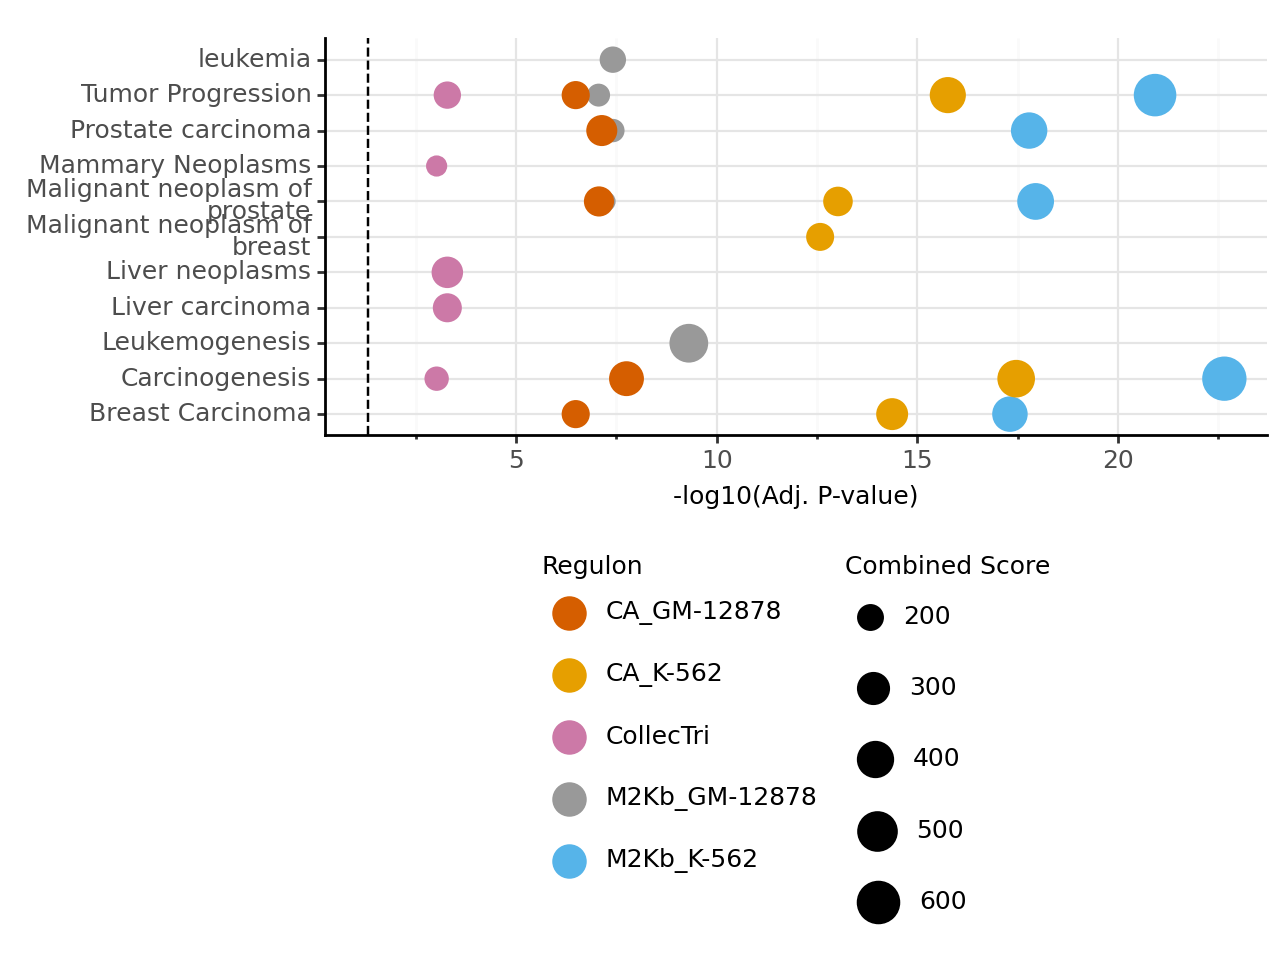

<Figure Size: (640 x 480)>

In [66]:
p = plot_enrich(aml_disreg_enrich, okabe)
ggsave(p, "../plots/3-tf_disease_enrichment/aml_go_enrich_disreg_dhsc_ahsc_new.svg",  width = 30, height = 150, units = "mm", dpi=720)
p

In [67]:
aml_cosmic_enrich["-log10(Adj. P-value)"] = - np.log10(aml_cosmic_enrich["Adjusted P-value"])
aml_cosmic_enrich = aml_cosmic_enrich.loc[aml_cosmic_enrich["Adjusted P-value"] < 0.05]
aml_cosmic_enrich.describe()

,P-value,Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,14.000000,14.000000,14.000000,14.000000,14.000000
mean,0.008530,0.023645,66.876133,333.857338,1.689124
std,0.008618,0.013231,68.490882,327.914939,0.240600
min,0.000309,0.010190,15.842105,68.556553,1.393300
25%,0.001779,0.013290,29.009217,182.074477,1.393300
50%,0.004169,0.016892,35.843636,210.501605,1.777833
75%,0.015602,0.040430,78.038095,335.763240,1.876461
max,0.023584,0.040430,252.200000,1276.986388,1.991819


/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/aml_go_enrich_cosmic_dhsc_ahsc_new.svg


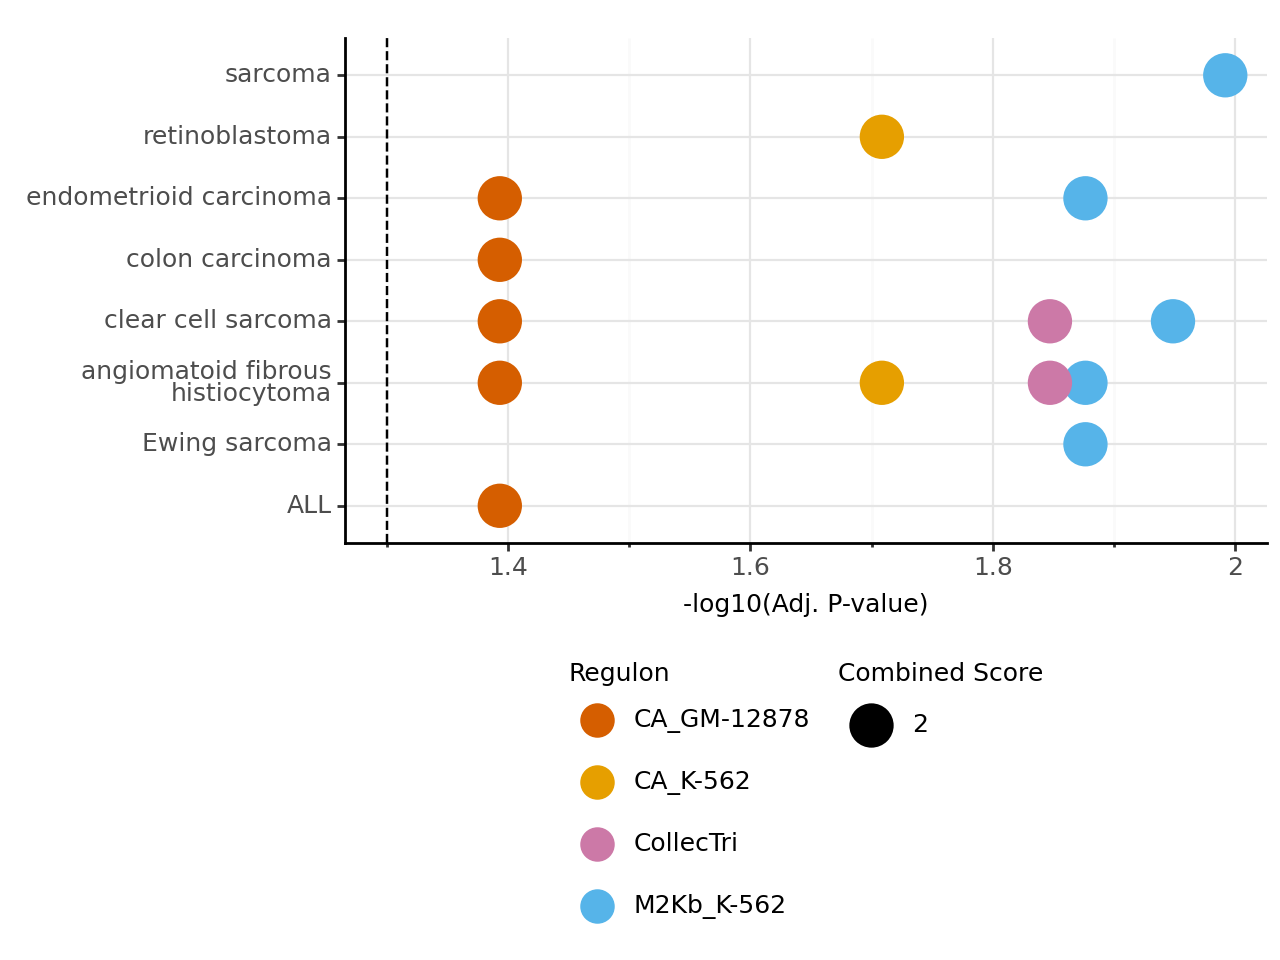

<Figure Size: (640 x 480)>

In [68]:
p = plot_enrich(aml_cosmic_enrich, [pal[6], pal[1], pal[7], pal[2]], size=2)
ggsave(p, "../plots/3-tf_disease_enrichment/aml_go_enrich_cosmic_dhsc_ahsc_new.svg", width = 30, height = 150, units = "mm", dpi=720)
p

In [69]:
megaheat.describe()

,score,p_value
count,846.000000,8.460000e+02
mean,1.539973,2.611110e-01
std,2.078696,3.030535e-01
min,-8.666896,8.561306e-18
25%,0.206704,2.599808e-03
50%,1.365132,1.171834e-01
75%,2.919831,4.670608e-01
max,7.118250,9.936623e-01


In [70]:
megaheat.to_csv("../data/3-tf_activity/aml_activity_estimates_dhsc_ahsc.tsv", sep="\t", index=False)

In [71]:
megaheat = megaheat[megaheat.p_value < 0.01].sort_values("score")
megaheat["TF"] = megaheat.index
megaheat["log_p"] = - np.log10(megaheat.p_value).round(1)
#megaheat["log_p"] = megaheat["log_p"].astype("str")

In [72]:
print(megaheat[megaheat.Network == "M2Kb_K-562"].sort_values("score").to_string())

            score       p_value     Network       TF  log_p
PRDM10   2.580295  9.937198e-03  M2Kb_K-562   PRDM10    2.0
NR2F1    2.580584  9.928891e-03  M2Kb_K-562    NR2F1    2.0
EWSR1    2.604489  9.264334e-03  M2Kb_K-562    EWSR1    2.0
CTCF     2.609543  9.129028e-03  M2Kb_K-562     CTCF    2.0
E2F7     2.633135  8.520500e-03  M2Kb_K-562     E2F7    2.1
ELF4     2.674845  7.532872e-03  M2Kb_K-562     ELF4    2.1
SMARCA5  2.674970  7.530086e-03  M2Kb_K-562  SMARCA5    2.1
PLAG1    2.679553  7.428118e-03  M2Kb_K-562    PLAG1    2.1
SMARCE1  2.750626  5.997845e-03  M2Kb_K-562  SMARCE1    2.2
ZNF143   2.828905  4.713953e-03  M2Kb_K-562   ZNF143    2.3
RFX1     2.856913  4.318837e-03  M2Kb_K-562     RFX1    2.4
ZNF263   2.865155  4.208421e-03  M2Kb_K-562   ZNF263    2.4
IRF2     2.888783  3.905949e-03  M2Kb_K-562     IRF2    2.4
TCF7     2.961136  3.098542e-03  M2Kb_K-562     TCF7    2.5
ZNF395   3.051066  2.308096e-03  M2Kb_K-562   ZNF395    2.6
USF1     3.080044  2.095815e-03  M2Kb_K-

In [73]:
print(megaheat[megaheat.Network == "CollecTri"].sort_values("score").to_string())

          score       p_value    Network     TF  log_p
RFX5  -8.666896  8.561306e-18  CollecTri   RFX5   17.1
RFX1  -5.004245  6.062165e-07  CollecTri   RFX1    6.2
IRF1  -4.248643  2.242190e-05  CollecTri   IRF1    4.6
CREB1 -3.624266  2.964938e-04  CollecTri  CREB1    3.5
YY1   -3.571998  3.620332e-04  CollecTri    YY1    3.4
THRA  -3.440546  5.915945e-04  CollecTri   THRA    3.2
MEF2A -2.943967  3.274992e-03  CollecTri  MEF2A    2.5
ATF3  -2.941248  3.303761e-03  CollecTri   ATF3    2.5
RELA  -2.857900  4.305477e-03  CollecTri   RELA    2.4
NR2C2 -2.769127  5.668788e-03  CollecTri  NR2C2    2.2
YBX1  -2.735002  6.289051e-03  CollecTri   YBX1    2.2
KLF1   2.616677  8.941054e-03  CollecTri   KLF1    2.0
MITF   4.227231  2.464550e-05  CollecTri   MITF    4.6
NFE2   4.751493  2.152257e-06  CollecTri   NFE2    5.7


In [74]:
print(megaheat[megaheat.Network == "M2Kb_GM-12878"].sort_values("score").to_string())

            score       p_value        Network       TF  log_p
BCL3     2.626845  8.679090e-03  M2Kb_GM-12878     BCL3    2.1
MAX      2.646734  8.186465e-03  M2Kb_GM-12878      MAX    2.1
ZBTB33   2.663752  7.784973e-03  M2Kb_GM-12878   ZBTB33    2.1
REST     2.700744  6.972569e-03  M2Kb_GM-12878     REST    2.2
RELB     2.752117  5.970708e-03  M2Kb_GM-12878     RELB    2.2
BHLHE40  2.759099  5.845062e-03  M2Kb_GM-12878  BHLHE40    2.2
SREBF2   2.762660  5.781905e-03  M2Kb_GM-12878   SREBF2    2.2
MXI1     2.790267  5.312797e-03  M2Kb_GM-12878     MXI1    2.3
MYC      2.794703  5.240715e-03  M2Kb_GM-12878      MYC    2.3
CREB1    2.795246  5.231947e-03  M2Kb_GM-12878    CREB1    2.3
MYB      2.876137  4.065286e-03  M2Kb_GM-12878      MYB    2.4
UBTF     2.929495  3.430785e-03  M2Kb_GM-12878     UBTF    2.5
CBFB     2.969266  3.018047e-03  M2Kb_GM-12878     CBFB    2.5
CREM     2.969471  3.016042e-03  M2Kb_GM-12878     CREM    2.5
USF1     2.974858  2.963801e-03  M2Kb_GM-12878     USF1

In [75]:
out = pd.DataFrame()
interesting_tf = ["YY1", "MYB", "MYC", "SP1", "CREB1"]
for net in ["CollecTri", "M2Kb_K-562", "M2Kb_GM-12878", "CA_K-562", "CA_GM-12878"]:
    mask = megaheat[megaheat.Network == net].score.abs().sort_values(ascending=False).head(5).index
    out = pd.concat([out, megaheat.loc[megaheat.TF.isin(mask) | megaheat.TF.isin(interesting_tf), :]])
plot_bubbles(out[out.Network.isin(["CollecTri", "M2Kb_K-562", "M2Kb_GM-12878", "CA_K-562", "CA_GM-12878"])], scale=0.15)
plt.savefig("../plots/3-tf_activity/aml_activity_clustermap_dhsc_ahsc.svg", dpi=720, format="svg")

/crex/proj/lappalainen_lab1/users/marii/chip_seq_ann/case_studies/plot_lib.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/crex/proj/lappalainen_lab1/users/marii/chip_seq_ann/case_studies/plot_lib.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


In [76]:
print(", ".join(megaheat[megaheat.Network == "M2Kb_GM-12878"].index.to_list()))

BCL3, MAX, ZBTB33, REST, RELB, BHLHE40, SREBF2, MXI1, MYC, CREB1, MYB, UBTF, CBFB, CREM, USF1, SMAD5, ZNF217, PKNOX1, RB1, SMARCA5, NR2F1, ETS1, NR2C1, PAX5, KLF5, ZNF143, GATAD2B, SIN3A, PBX3, IRF3, ZEB1, BCL11A, RXRA, E4F1, SIX5, RELA, TCF3, MAZ, ARID3A, MED1, BACH1, ELF1, TCF12, SP1, TAF1, EGR1, HCFC1


In [77]:
print(", ".join(megaheat[megaheat.Network == "M2Kb_K-562"].index.to_list()))

PRDM10, NR2F1, EWSR1, CTCF, E2F7, ELF4, SMARCA5, PLAG1, SMARCE1, ZNF143, RFX1, ZNF263, IRF2, TCF7, ZNF395, USF1, CREB3L1, MTA3, ZMIZ1, ZHX1, ATF7, NR2C2, ESRRB, EP300, PML, REST, SRF, NR4A1, GMEB1, KLF1, ERG, VEZF1, HIF1A, PHF8, SMAD1, E2F6, ESRRA, TFDP1, CTBP1, TBL1XR1, E2F3, JUND, GATAD2B, USF2, NR2F2, CREB1, FUS, ZBTB7A, NFYB, HDGF, KLF13, ZBED1, SKIL, IRF1, SREBF1, EGR1, GABPA, ZFX, MAX, ELF1, CTCFL, TBP, TAF1, NEUROD1, SMAD5, SP1, MXI1, JUN, SIN3B, NRF1, YY1, MNT, BHLHE40, GFI1B, MAZ, BRD4, NFYA, MBD2, HDAC1, NONO, THAP1, KDM5B, UBTF, RB1, GTF2F1, SAP30, E2F4, MYC, HCFC1, SIN3A, ETS1


In [78]:
print(", ".join(megaheat[megaheat.Network == "CollecTri"].index.to_list()))

RFX5, RFX1, IRF1, CREB1, YY1, THRA, MEF2A, ATF3, RELA, NR2C2, YBX1, KLF1, MITF, NFE2


In [79]:
enr = gp.enrich(megaheat[megaheat.Network == "CollecTri"].index.to_list(), "KEGG_2021_Human")
enr.results.head(10)
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_kegg_enrich_collectri_dhsc_ahsc.tsv", sep="\t", index=False)

In [80]:
enr = gp.enrich(megaheat[megaheat.Network == "M2Kb_K-562"].index.to_list(), "KEGG_2021_Human")
enr.results.head(10)
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_kegg_enrich_m2kb_k562_dhsc_ahsc.tsv", sep="\t", index=False)

In [81]:
enr = gp.enrich(megaheat[megaheat.Network == "M2Kb_GM-12878"].index.to_list(), "KEGG_2021_Human")
enr.results.head(10)
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_kegg_enrich_m2kb_gm12878_dhsc_ahsc.tsv", sep="\t", index=False)